# Google Apps Price Analyst

#### _Group Member: Yingjie Gao, Dan Shao, Weiyao Ma_
 
**** 
### <font color=navy>Agenda: Background → Data Manipulation → Feature Engineering → Modeling & Finding → Suggestions</font>

## <font color=navy>Background</font>

Nowadays, apps affect all aspects of our life, such as Uber, Twitter, Yelp, etc. These apps make people's life more convenient, improve production efficiency, and provide more choices and possibilities. More importantly, they contain a lot of valuable information worth studying. By mining the information of app store, we would have a deeper understanding of this field to help app developers find business opportunities, make decisions and adjust the app in time. We can also gain some insights about people or society. After researching for this topic, we found that there have been many comprehensive analyses for iOS Apps, but conversely, analysis for Apps in Android, actually the most popular mobile operating system, is not that much, so we choose a dataset focusing on Android Apps market to study.

****

###  Objectives
We mainly focus on three key objects: rating, pricing, and comments which are also the app developers care most when they design and launch their products. And the associated objective questions relevant to these three objects are demonstrating below:

**Rating:**
1. Rating distribution in different categories: Whether ratings show a difference in different categories? Is that difference is statistically significant, or not? Have an overview of apps' ranking as a preparation for further analysis.
2. Relationship between other variable and rating: How other app features impact on rating? What is the most influential feature?
3. Regression of rating (or another modeling): Based on the previous question, we can do simple regression as well as another model such as Tree to predict how a new app performs on rating in Google App Store.

**Pricing:**
1. Free VS Paid: What is the proportion of free app? For paid apps, what is the pricing distribution for them?
2. Price distribution in different categories: For all paid apps, how about the pricing distribution in different types?
3. Relationship between other variables and price: For all paid apps, what factor is the most influential factor in pricing?
4. Regression of pricing (modeling): Building a model to predict whether an app should be charged or not? If yes, what might be its optimal price?

**Reviews:**
1. What is the number of comments most people have, long comments or short comments?
2. High-frequency positive adjective words: What customers appreciate most for apps?
3. High-frequency negative adjective words: What customers complaint most for the apps?

****
Our dataset is from Kaggle dataset provided by Lavanya Gupta who scraped it from Google Play Store (https://play.google.com/store/apps) and updated last month. The data includes two csv files: **googleplaystore.csv** and **googleplaystore_user_reviews.csv**.

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
sns.set()
%pylab inline
import nltk
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the first csv file
pd.set_option('display.max_colwidth', -1)
app = pd.read_csv('googleplaystore.csv', header=0)
app.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide Apps",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
# load the Second csv file
reviews = pd.read_csv('googleplaystore_user_reviews.csv', header=0)
reviews.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,"I like eat delicious food. That's I'm cooking food myself, case ""10 Best Foods"" helps lot, also ""Best Before (Shelf Life)""",Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


## <font color=navy>Data Manipulation </font>

The datasets are messy, so we did a lot of data cleaning in our full report. We only show part of them due to the time limits:

* Installs
* Size
* Last Updated
* Genres
* Translated_Review 

#### Installs (Drop "+" and ",")

In [34]:
# drop "+" and ","
app.Installs=app.Installs.apply(lambda x: x.strip('+'))
app.Installs=app.Installs.apply(lambda x: x.replace(',',''))
app.Installs.head()

0       10000
1      500000
2     5000000
3    50000000
4      100000
Name: Installs, dtype: int64

#### Size (Replacing k and M with their values)

In [140]:
# Replacing k and M with their values to convert values to numeric
app.Size=app.Size.str.replace('k','e+3')
app.Size=app.Size.str.replace('M','e+6')

# defined a funtion to covert data type
def is_convertable(data):
    try:
        float(data)
        return True
    except ValueError:
        return False
    
numeric=app.Size.apply(lambda x: is_convertable(x))

# Replacing 'Varies with device' by nan
app.Size=app.Size.replace('Varies with device',0)
# Converting 1,000+ to 1000
app.Size=app.Size.replace('1,000+',1000)app.Size.head()
app.Size.head()

0    19000000.0
1    14000000.0
2    8700000.0 
3    25000000.0
4    2800000.0 
Name: Size, dtype: float64

Text(0, 0.5, 'Frequency')

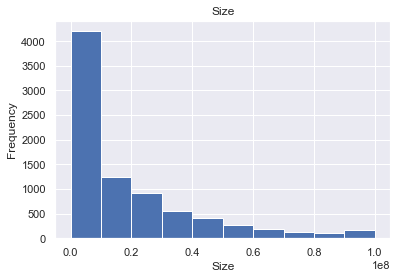

In [29]:
app.hist(column='Size')
plt.xlabel('Size')
plt.ylabel('Frequency')

The largest app size is between 90-100M and most apps are less than 20M.

#### Last Updated (Taking a difference between last updated date and today)

In [49]:
#Create a new column called 'Last_Updated_Days': integer indicating how many days passed since last update
from datetime import datetime,date
temp=pd.to_datetime(app['Last Updated'])
app['Last_Updated_Days'] = temp.apply(lambda x:date.today()-datetime.date(x))
app['Last_Updated_Days'] = app.Last_Updated_Days.apply(lambda x: str(x).split(' ')[0])
app['Last_Updated_Days'] = pd.to_numeric(app.Last_Updated_Days)
# The top 10 app that hasn't been updated for the longest time
app[['App','Last_Updated_Days']].sort_values(by='Last_Updated_Days',ascending=False).head()

,App,Last_Updated_Days
7479,FML F*ck my life + widget,3274
7430,CJ Poker Odds Calculator,3020
10282,FD Shift Calendar Widget,2975
8418,DEER HUNTER CHALLENGE,2949
8084,Freecell CY,2944


#### Genres (Divide into two new columns)

As shown before, the data is in the format 'Art & Design;Pretend Play'. 

Lets divide the data into two columns, one as primary category and the other as secondary, using ; as separator.

In [41]:
# split and create a new column for primary category
rest = app.Genres.apply(lambda x: x.split(';')[0])
app['Pri_Genres']=rest
app.Pri_Genres.head()

0    Art & Design
1    Art & Design
2    Art & Design
3    Art & Design
4    Art & Design
Name: Pri_Genres, dtype: object

#### Translated_Review (Text Process)

In [58]:
# Lower case
reviews['Translated_Review'] = reviews['Translated_Review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
# Removing Punctuation (remove all Punctuation except words and space)
reviews['Translated_Review'] = reviews['Translated_Review'].str.replace('[^\w\s]','')
# Removal of Stop Words and also some other words
from nltk.corpus import stopwords
stop = stopwords.words('english')
added = ['ive','im','us','star','would','go','even','5','live','give','get']
reviews['Translated_Review'] = reviews['Translated_Review'].apply(lambda x: " ".join(x for x in x.split() 
# Lemmatizataion (convert helps to help)
lmtzr = WordNetLemmatizer()
reviews['Translated_Review'] = reviews['Translated_Review'].apply(lambda x: " ".join(lmtzr.lemmatize(x,pos='v') for x in x.split()))
reviews['Translated_Review'].to_frame().head(5)

,Translated_Review
0,like eat delicious food thats cook food case 10 best foods help lot also best shelf life
1,help eat healthy exercise regular basis
3,work great especially go grocery store
4,best idea
5,best way


**Date set after clean:**

In [147]:
app.head().drop(['Last Updated','Genres','Current Ver','Android Ver'],axis=1)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Pri_Genres,Last_Updated_Days
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19000000.0,10000,Free,0.0,Everyone,Art & Design,486
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14000000.0,500000,Free,0.0,Everyone,Art & Design,478
2,"U Launcher Lite – FREE Live Cool Themes, Hide Apps",ART_AND_DESIGN,4.7,87510.0,8700000.0,5000000,Free,0.0,Everyone,Art & Design,280
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25000000.0,50000000,Free,0.0,Teen,Art & Design,334
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2800000.0,100000,Free,0.0,Everyone,Art & Design,322


#### Price overview

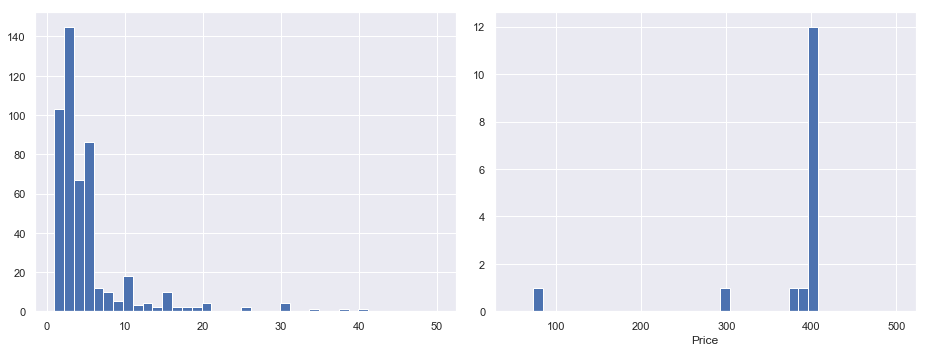

In [170]:
fig, axs = plt.subplots(1,2, sharey=False,figsize=(13, 5))
axs[0].hist(app.Price, bins=np.linspace(1, 50, 40))
axs[1].hist(app.Price, bins=np.linspace(50, 500, 40))
plt.xlabel('Price')
plt.tight_layout()

It is abnormal that there are some super expensive apps whose prices are over $350! And I checked some of them in the Google Play Store, it was surprised me that they are indeed existing...! So we will just keep them in our dataset.

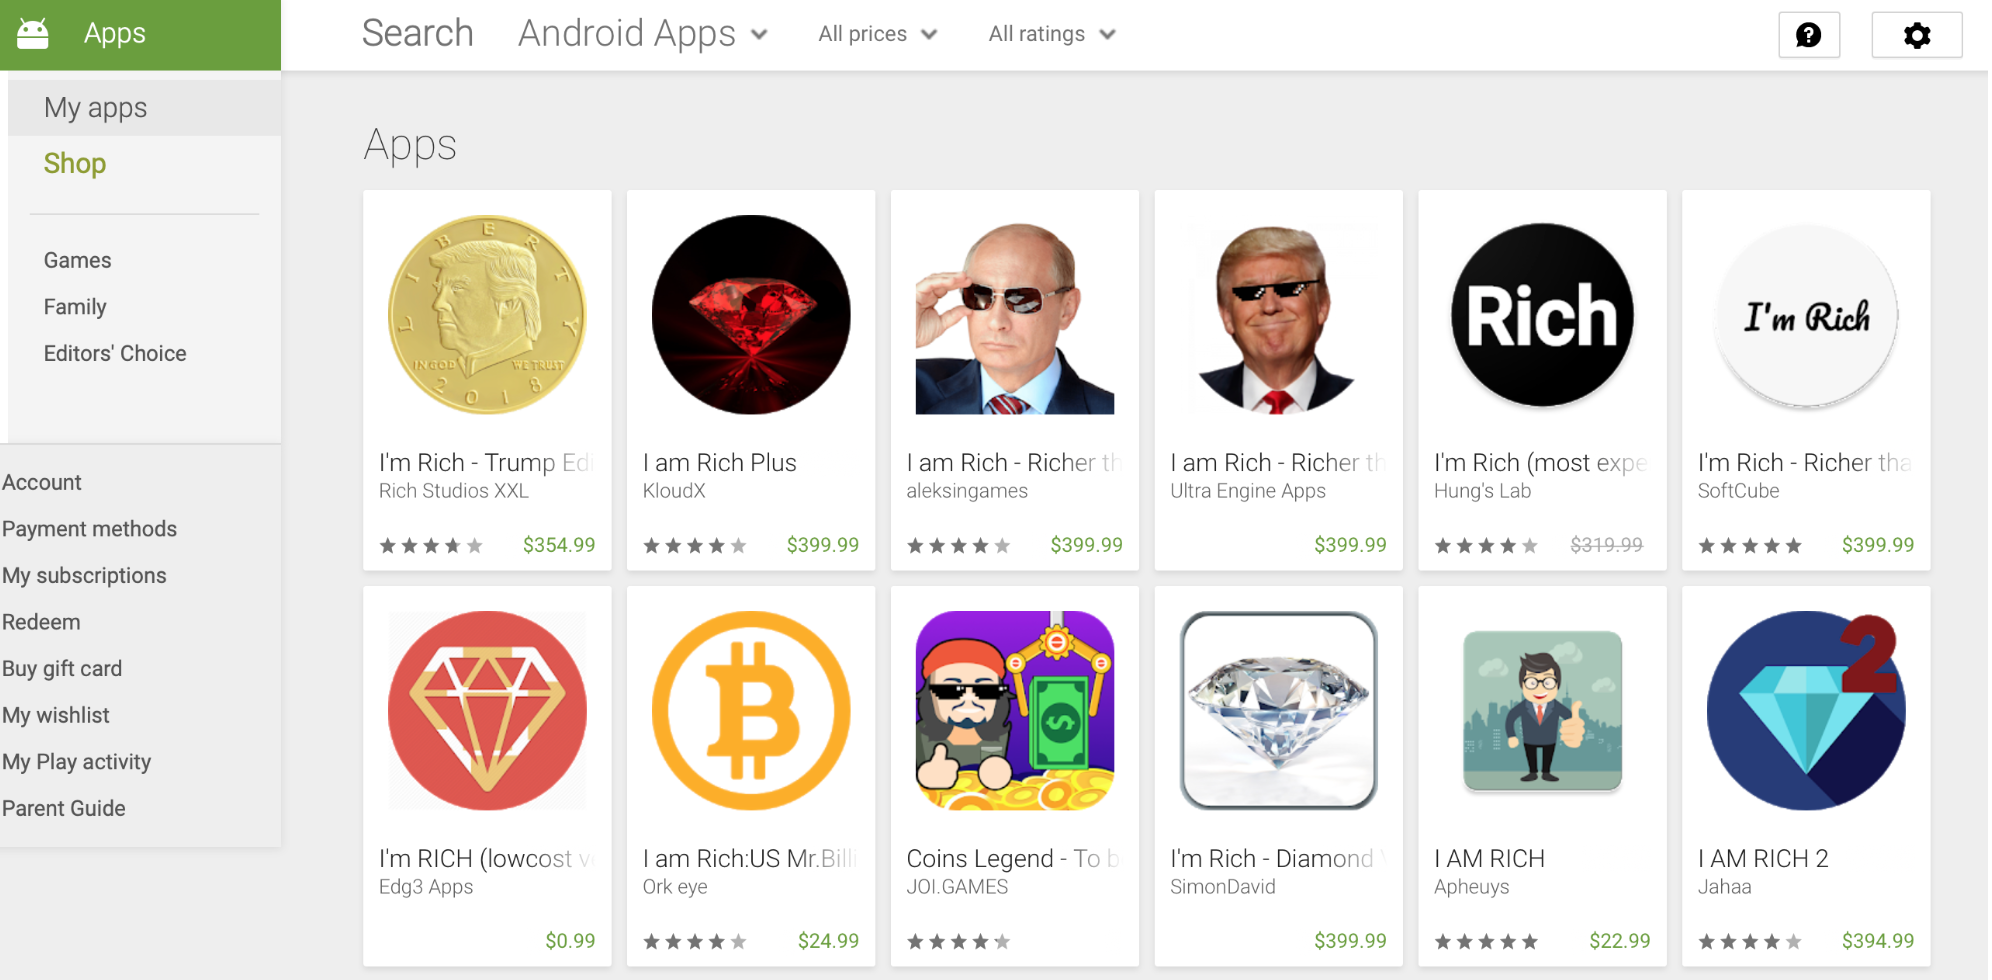

Most of apps are charged under 10 USD, but some apps are extremely expensive, which attract a lot of conspicuous consumptions.

#### Rating overview

Text(0, 0.5, 'Frequency')

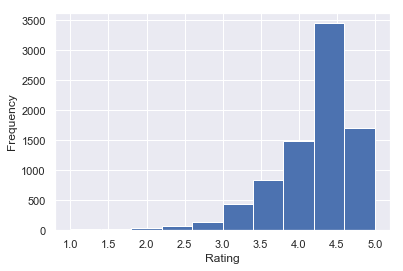

In [18]:
app.Rating.hist(bins=10);
plt.xlabel('Rating')
plt.ylabel('Frequency')

Most of apps are over 4 points, and the average rating is 4.17.

#### Category overview

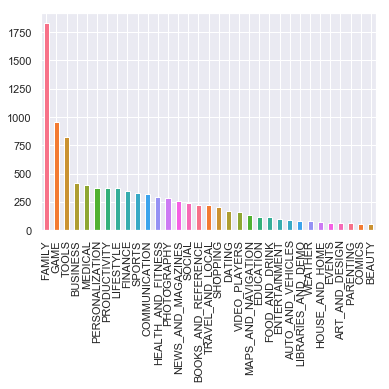

In [13]:
app.Category.value_counts().plot(kind='bar', color=sns.color_palette("husl", 15))

Family has the largest number of apps, followed by game and tool. Beauty has the least quantity.

## <font color=navy>Feature Engineering</font>

#### Rating:

**1. Rating distribution in different categories: Whether ratings show difference in different categories?**

The difference between apps of different categories in rating seems not so obvious. Basically, most of the rating of all categories are distributed **around the average (blue line)**. It seems that apps in different categories are all fairly good on rating. But is that really the case? This question leads to our next finding.

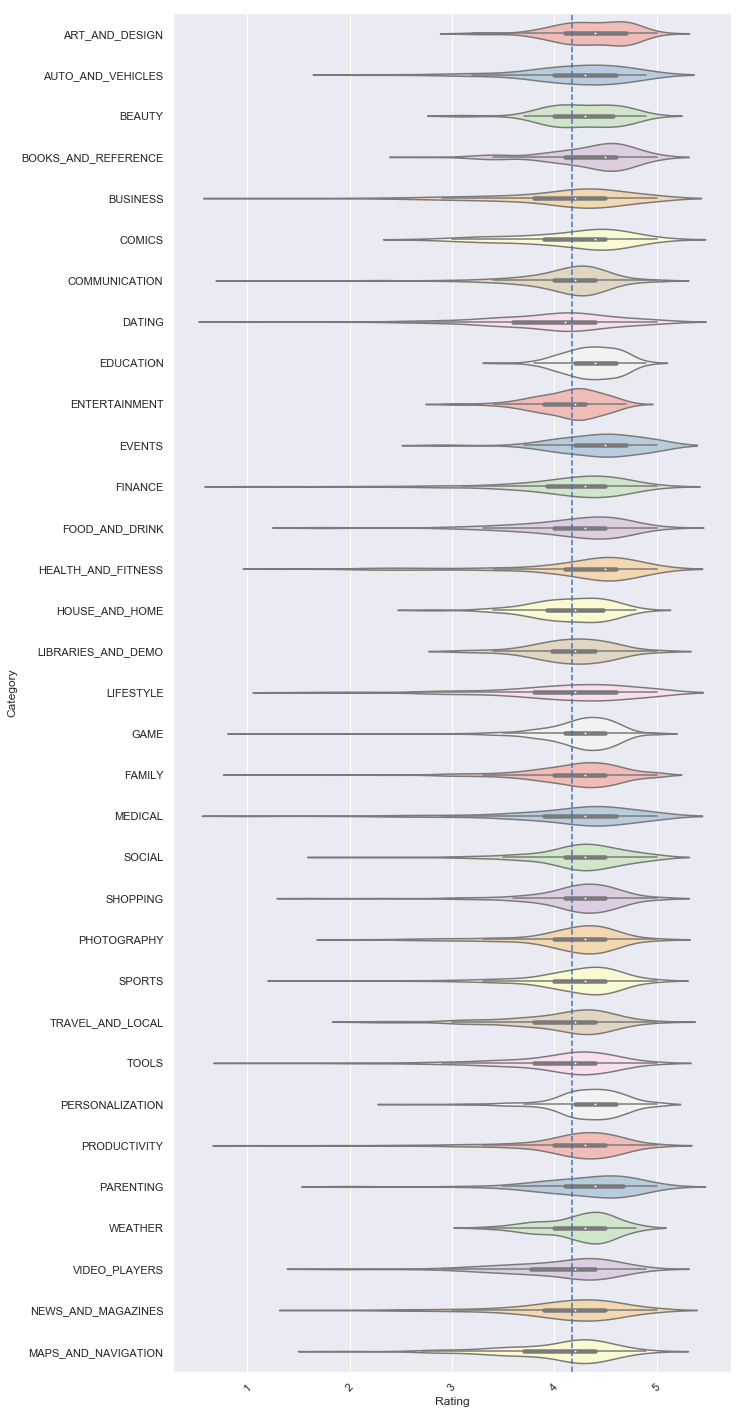

In [57]:
fig, ax = plt.subplots(figsize=(10,25))
sns.violinplot(y="Category", x="Rating", data=app, palette="Pastel1",orient='h')
plt.xticks(rotation=45)
ax.axvline(4.17, ls='--')

**2. Is that difference statistically significant, or not?**

In order to verify whether all these different categories perform equally well in rating, we apply one-way analysis of variance（ANOVA) to calculate the p-value of these series. The one-way analysis of variance (ANOVA) is used to determine whether there are any statistically significant differences between the means of two or more groups. Results show that the average app ratings across categories is **significantly different**, and the p-value is very small, only 3.45e-30. In other words, app scores are higher in some categories and lower in others. 

Next, we tried to find which category is always different from other categories on rating. Then we made a heatmap to see p-values of one-way ANOVA analysis between each pairs of categories. We find there are several categories that are significantly different from others, such as' EDUCATION, ' 'DATING,' and 'PERSONALIZATION.' In reality, for apps in the 'EDUCATION'category, users tend to have high income or high education, tend to give a relatively fair score when scoring, and even consciously do not give a low score. 'PERSONALIZATION' apps often provide users customized content and services, thus earning higher evaluation. However, in the category of 'DATING', users may give low scores irrationally for some personal reasons.

In [61]:
# One-way ANOVA: for all 33 categories
stats.f_oneway(ART_AND_DESIGN, AUTO_AND_VEHICLES, BEAUTY, BOOKS_AND_REFERENCE, BUSINESS, COMICS, COMMUNICATION, 
               DATING, EDUCATION, ENTERTAINMENT, EVENTS, FINANCE, FOOD_AND_DRINK, HEALTH_AND_FITNESS, HOUSE_AND_HOME, 
               LIBRARIES_AND_DEMO, LIFESTYLE, GAME, FAMILY, MEDICAL, SOCIAL, SHOPPING, PHOTOGRAPHY, SPORTS, 
               TRAVEL_AND_LOCAL, TOOLS, PERSONALIZATION, PRODUCTIVITY, PARENTING, WEATHER, VIDEO_PLAYERS, 
               NEWS_AND_MAGAZINES, MAPS_AND_NAVIGATION)

F_onewayResult(statistic=6.9993549749623245, pvalue=3.4525319466034365e-30)

We can find some categories with a large number of dark blocks in the heatmap, such as **EDUCATION, DATING and PERSONALIZATION**. These categories are obviously different from others in the rating.

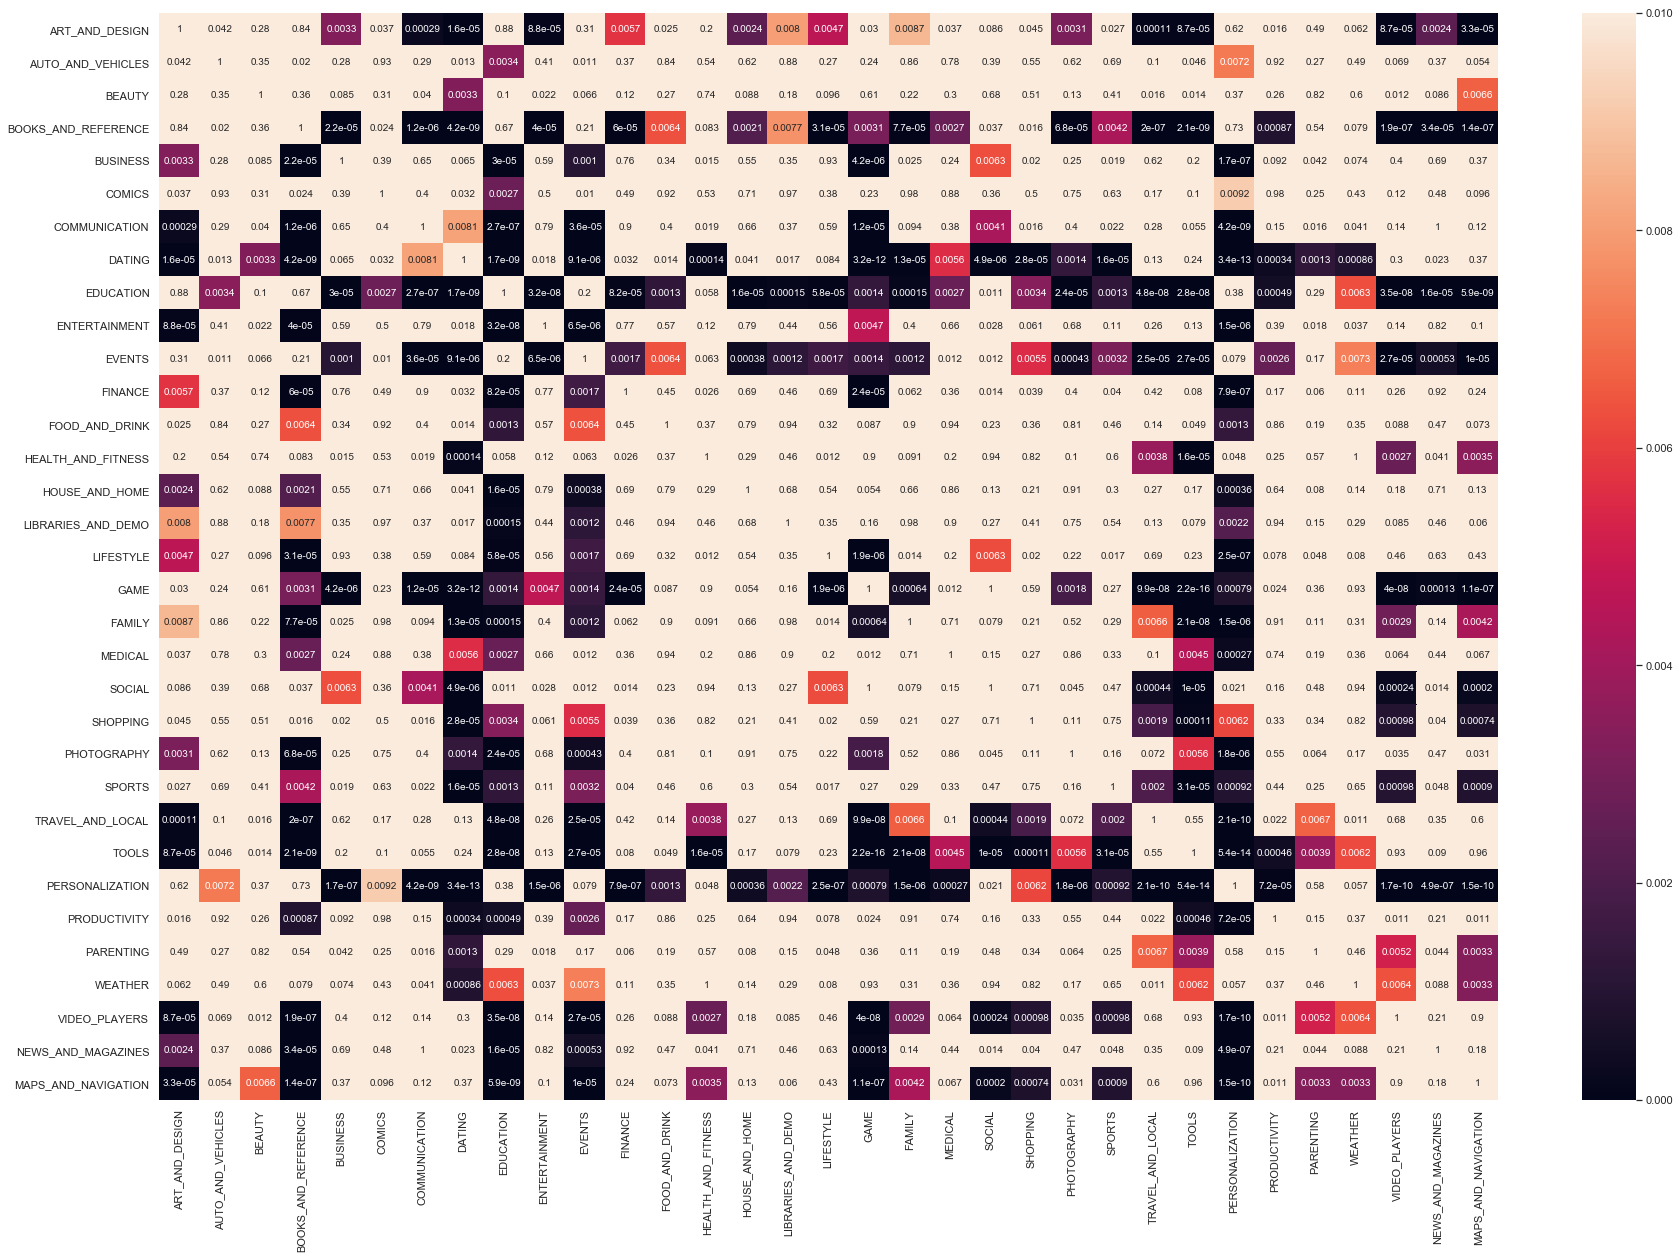

In [63]:
f, ax = plt.subplots(figsize=(30, 20))
sns.heatmap(ANOVA, annot=True,vmax=0.01)

**3. Relationship between other variable and rating: How other app features impact on rating?**

We can only calculate the correlation rate for all numeric variables, so this correlation analysis is not particularly comprehensive. A more comprehensive analysis will be reflected in the modeling section later. As far as our visualized correlation rates are concerned, most of the correlations between numeric variables are **not very significant**. 

In particular, the main variable we discussed, **Rating, is almost not related to any other single numeric variable,** but it also indicates that rating is a variable reflected by multiple aspects of an app. In addition, it is worth to mention that the correlation between **Installs and Reviews reached 0.624**, indicating that these two variables showed **relatively strong positive correlation**. In the next stage Modeling, we will pay more attention to the interaction of these two variables.

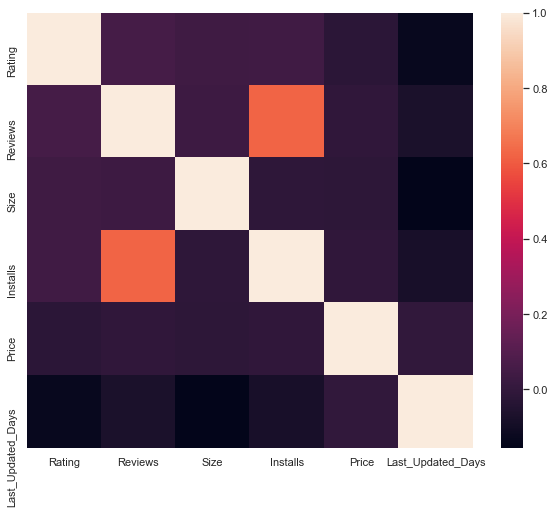

In [65]:
f, ax = plt.subplots(figsize=(10, 8))
corr = app.iloc[:,[2,3,4,5,7,15]].corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [66]:
app['Installs'].corr(app.Reviews)

0.6240556233042991

#### Pricing:

**1. Free VS Paid: What is the proportion of free app?**

7592 out of 8196 apps are free, the proportion is 92.63%, which is very high. But are they really purely 'free' for users? The answer is probably NO.

Some free apps usually act as add-ons to an established product or service. The goal is not to make money directly from the app, but instead to drive people to other revenue streams. Those services ultimately make money for the company, even if the app itself has no price tag. Some free apps are platforms for ad revenue.

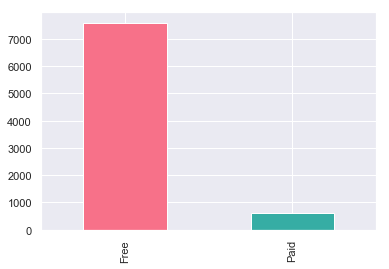

In [68]:
app.Type.value_counts().plot(kind='bar', color=sns.color_palette("husl", 2))

**2. What is the pricing range for most apps？**

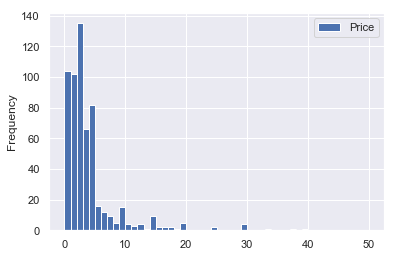

In [77]:
Paid = app[app['Price']>0]
Paid.plot(y='Price', kind='hist', bins=50, range=(0,50))

Among paid apps, the most apps are priced in the range of $2-3.

**3. Price distribution in different categories**

We focus on the prices of four categories, 'FAMILY ', 'FINANCE', 'LIFESTYLE' and 'MEDICAL'. 'FAMILY' has the most paid apps, while the latter three have the highest average app charges. We want to explore why these three categories of apps are particularly expensive. Through the price distribution, we find that the high prices of these three categories‘ apps are partly caused by very expensive apps.

Text(0.5, 1.0, 'Scatterplot of Price VS Category')

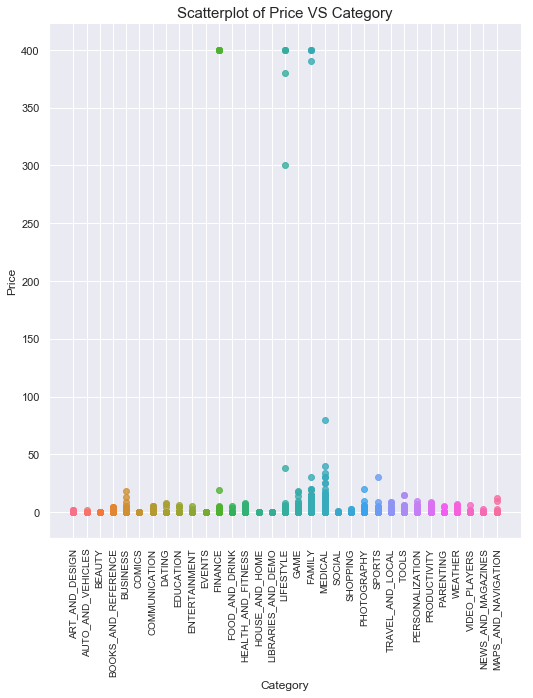

In [80]:
sns.lmplot(x='Category', y='Price', data=app, fit_reg=False, legend=False, 
           hue="Category",height=8)
plt.xticks(rotation=90,size=10)
plt.title('Scatterplot of Price VS Category',size = 15)

In [92]:
app[app['Price']>399][['App','Category','Price']]

,App,Category,Price
4197,most expensive app (H),FAMILY,399.99
4362,💎 I'm rich,LIFESTYLE,399.99
4367,I'm Rich - Trump Edition,LIFESTYLE,400.00
5351,I am rich,LIFESTYLE,399.99
5354,I am Rich Plus,FAMILY,399.99
5356,I Am Rich Premium,FINANCE,399.99
5358,I am Rich!,FINANCE,399.99
5359,I am rich(premium),FINANCE,399.99
5362,I Am Rich Pro,FAMILY,399.99
5364,I am rich (Most expensive app),FINANCE,399.99


**4. Relationship between other variables and price**

According to the first graph below, Paid apps have higher average rating than free apps but **WHY**? And from the second scatter plot, we can see that super expensive apps have lower rating. Maybe this is because that higher-priced apps may make customer disappointed, if they are not good enough. So the higher average rating of paid apps is defintely not caused by those extremely expensive apps, may be those low-charge apps are the biggest reason. 

In order to provide evidence to our guess, we then divide the price range to four groups, Free (0), Cheap (1-10), Medium (10-50) and Expensive (>50), to see the rating of each group so that we could eliminate noise caused by too many Free apps and several super expensive apps. What we found is **Cheap apps achieved highest score  (avg=4.27), Medium price apps (avg=4.22) perform slightly better on rating than Free apps (avg=4.16), and Expensive apps (avg=3.91) have very bad user feedback.** So we can conclude that the reason why paid apps have higher average rating than free apps is because the group with price ranging from 0 to 10 have higher average rating. 

To be more specific, we can infer that many cheap paid apps (price < $10) are very well-designed and generate very nice user experience with additional premium functions and outstanding solutions that make customers are willing to pay even though they have many other free options.

Text(0.5, 1.0, 'Boxplot of Rating VS Type')

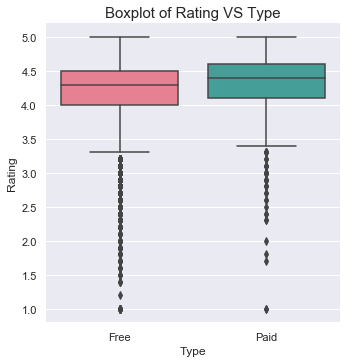

In [84]:
g = sns.catplot(x="Type",y="Rating",data=app, kind="box", height = 5,palette = "husl")
g.despine(left=True)
g.set( xticks=range(0,2))
g = g.set_ylabels("Rating")
plt.title('Boxplot of Rating VS Type',size = 15)

Text(0.5, 1.0, 'Scatter plot Rating VS Price')

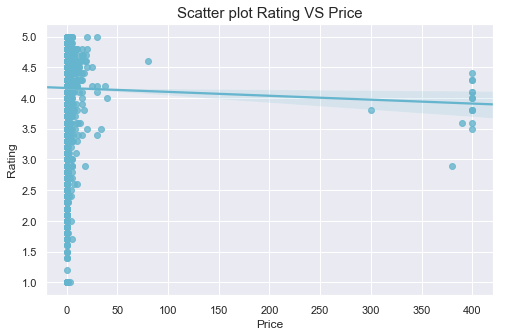

In [86]:
plt.figure(figsize = (8,5))
sns.regplot(x="Price", y="Rating", color = 'c',data=app[app['Reviews']<1000000]);
plt.title('Scatter plot Rating VS Price',size = 15)

In [87]:
price_rate = app[['Price','Rating']]
price_rate.loc[ price_rate['Price'] == 0, 'PriceBand'] = 'Free'
price_rate.loc[(price_rate['Price'] > 0) & (price_rate['Price'] <= 10), 'PriceBand'] = 'Cheap'
price_rate.loc[(price_rate['Price'] > 10) & (price_rate['Price'] <= 50), 'PriceBand'] = 'Medium'
price_rate.loc[(price_rate['Price'] > 50), 'PriceBand']  = 'Expensive'

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Text(0.5, 1.0, 'Boxen plot Rating VS PriceBand')

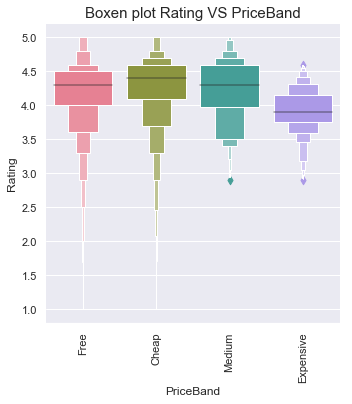

In [82]:
plt.figure(figsize = (8,5))
sns.regplot(x="Price", y="Rating", color = 'b',data=app[app['Reviews']<1000000]);
plt.title('Scatter plot Rating VS Price',size = 15)plt.figure(figsize = (8,5))
sns.regplot(x="Price", y="Rating", color = 'b',data=app[app['Reviews']<1000000]);
plt.title('Scatter plot Rating VS Price',size = 15)g = sns.catplot(x="PriceBand",y="Rating",data=price_rate, kind="boxen", height = 5 ,palette = "Pastel1")
g.despine(left=True)
g.set_xticklabels(rotation=90)
g = g.set_ylabels("Rating")
plt.title('Boxen plot Rating VS PriceBand',size = 15)

#### Reviews:

**1. What is the number of comments most people have, long comments or short comments?**

In [83]:
# how many words in Positive reviews
Ptext_word_counts = reviews[reviews['Sentiment']=='Positive'].Translated_Review.apply(lambda x: 
                                                                                      len(str(x).split(" ")))
# how many words in Negative reviews
Ntext_word_counts = reviews[reviews['Sentiment']=='Negative'].Translated_Review.apply(lambda x: 
                                                                                      len(str(x).split(" ")))
print('There are {} Positive reviews and {} Negative reviews.'.format(Ptext_word_counts.count(),
                                                                     Ntext_word_counts.count()))

There are 23998 Positive reviews and 8271 Negative reviews.


In [84]:
# Most common number of words in Positive reviews (Top 5)
Ptext_word_counts.value_counts(sort=True)[:5]

1    2129
2    1423
3    1230
4    1048
5    1000
Name: Translated_Review, dtype: int64

In [85]:
# Most common number of words in Negative reviews (Top 5)
Ntext_word_counts.value_counts(sort=True)[:5]

11    312
12    310
9     310
8     297
3     297
Name: Translated_Review, dtype: int64

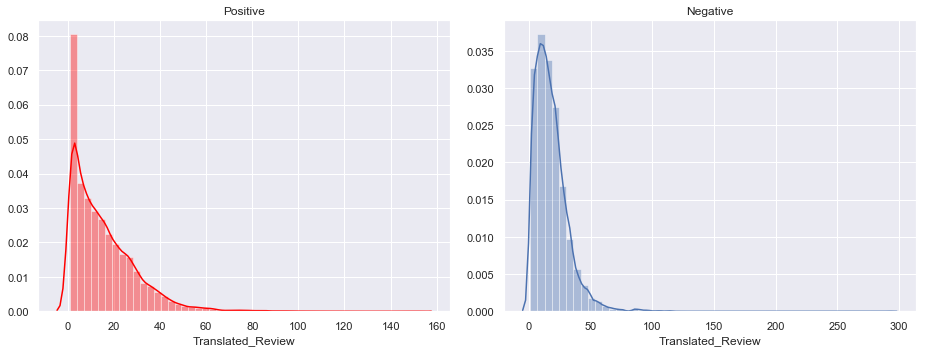

In [86]:
# The distribution of the number of words in positive and negative comments
f, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.distplot(Ptext_word_counts , color="red",ax=axes[0],label='Positive').set_title('Positive')
sns.distplot(Ntext_word_counts , color="b").set_title('Negative')
plt.tight_layout()

Comments are great feedback for application developers. Positive feedback encourages developers, and negative feedback also helps developers improve the quality of apps. We counted the number of words of each positive comment, and calculated the frequency too see how the extent to which people are willing to share their opinions about the apps. 

Unfortunately, most people don't bother to take the time to give specific comments. No matter positive or negative comments, most users tend to make short comments. The longest comment had 300 words，which is negative. Most people's comments are less than 50 words and people who gave only one word of comment were the most. People are more reluctant to spend time on positive comments. Our analysis on reviews has been limited due to the above reasons. 

Obviously, developers or the Google App Store didn't do a good job on effectively encouraging users to leave comments. To some extent, this suggests that they are underestimating the importance of comments or that increasing the number of comments is a costly task. However, developers need to take comments seriously as an important channel for gaining user experience. If there are some keywords or phrases available for users to choose when commenting (without direct input from users), it is likely to get more information. And it is also convenient for developers to review and analyze comments. The keywords can be "improve efficiency", "easy to use" or  "I will recommend it to my friends", which can save users time and help developers understand more user experience as well.

**2. High-frequency positive adjective words: What customers appreciate most for apps ?**

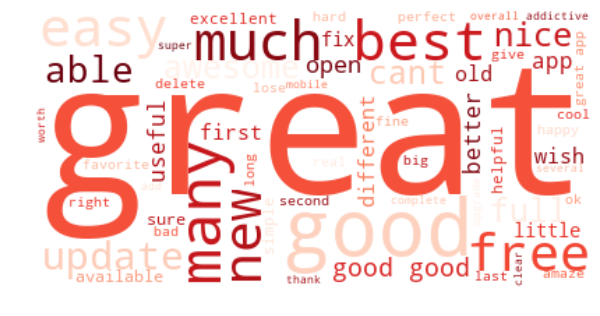

In [88]:
# select and combine all comments from Positive review
Positive_text = " ".join(review for review in reviews[reviews['Sentiment']=='Positive'].Translated_Review)
P_tokens = nltk.word_tokenize(Positive_text)
P_tags = nltk.pos_tag(P_tokens)
Positive_adj = [word for word, pos in P_tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS')]
# JJ adjective ‘big’ # JJR adjective, comparative ‘bigger’ # JJS adjective, superlative ‘biggest’

# Create and generate a word cloud image
plt.figure(figsize=(10,10))
wordcloud = WordCloud(max_font_size=1000, max_words=60,
                      background_color='white',colormap="Reds").generate(" ".join(Positive_adj))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [89]:
Positive_words = reviews[reviews['Sentiment']=='Positive'].Translated_Review
# Counter from Collections Module
P_words = " ".join(Positive_words).split()
Text(P_words).collocations(20)

full review; please fix; highly recommend; easy use; many ads; user
friendly; every time; latest update; great app; love app; love game;
keep track; work fine; much better; wish could; free version; five
star; really like; work well; spend money


In [91]:
#trigrams
trigrams = nltk.collocations.TrigramAssocMeasures()
trigramFinder_P = nltk.collocations.TrigramCollocationFinder.from_words(P_words,window_size=3)
trigram_freq = trigramFinder_P.ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)

In [92]:
trigramFreqTable.head(10)

,trigram,freq
408,"(keep, good, work)",88
1098,"(way, many, ads)",74
25154,"(best, game, ever)",73
6599,"(love, love, love)",73
25155,"(game, ever, play)",60
1073,"(game, love, game)",54
18749,"(love, game, much)",42
2829,"(really, like, app)",40
3753,"(every, time, try)",37
34816,"(great, time, killer)",37


When a user downloads an app, the first thing they see is ratings and reviews. Comprehensive reviews can help new users choose apps efficiently and also help developers improve the app. Reviews are a direct reflection of the app quality and user experiences. 

Among all the positive comments of apps, we can find that popular apps share some common features through the analysis of word frequency. Aside from complimentary words like great, good, the keywords in the word cloud have **free**, **clear**, **helpful**, **available**, and the key phrases has **user friendly**, **free version**, **work well**, **latest update** and more. From these words, we can conclude users care about whether apps are useful, whether app updates regularly and whether they are easy to use when judging an app. Developers who always keep those in mind when developing new apps are more likely to succeed. 

Besides, the word frequency of **"game"** is very high, which may be because compared with other types of apps, users are more inclined to review game apps, which should be noticed by developers. Negative words like **"way, many, ads"** with high frequency also appear in positive comments, this reminds developers that they may need to adjust the play frequency and length of the ads.

**3. High-frequency negative adjective words: What customers complaint most for the apps ?**

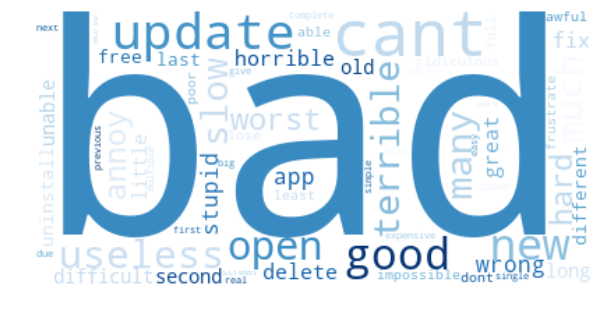

In [94]:
# select and combine all comments from Negative review
Negative_text = " ".join(review for review in reviews[reviews['Sentiment']=='Negative'].Translated_Review)

# select all Negative adjective words
N_tokens = nltk.word_tokenize(Negative_text)
N_tags = nltk.pos_tag(N_tokens)
Negative_adj = [word for word, pos in N_tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS')]
# JJ adjective ‘big’ # JJR adjective, comparative ‘bigger’ # JJS adjective, superlative ‘biggest’

# Create and generate a word cloud image
plt.figure(figsize=(10,10))
wordcloud = WordCloud(max_font_size=1000, max_words=60,
                      background_color='white',colormap="Blues").generate(" ".join(Negative_adj))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [95]:
Negative_words = reviews[reviews['Sentiment']=='Negative'].Translated_Review
# Counter from Collections Module
N_words = " ".join(Negative_words).split()
Text(N_words).collocations(20)

please fix; waste time; every time; love game; play game; angry bird;
gift card; every single; spend money; candy crush; long time; take
forever; last update; many ads; credit card; dont waste; worst ever;
full review; take long; new update


In [97]:
# trigrams
trigramFinder_N = nltk.collocations.TrigramCollocationFinder.from_words(N_words,window_size=3)
trigram_freq = trigramFinder_N.ngram_fd.items()
trigramFreqTable = pd.DataFrame(list(trigram_freq), columns=['trigram','freq']).sort_values(by='freq', ascending=False)

In [98]:
trigramFreqTable.head(10)

,trigram,freq
504,"(dont, waste, time)",53
1029,"(take, forever, load)",30
1991,"(every, single, time)",29
854,"(really, like, game)",29
6595,"(game, ever, play)",26
1327,"(game, like, game)",23
10307,"(take, long, time)",23
2647,"(every, time, try)",22
6110,"(way, many, ads)",20
24736,"(cant, play, game)",20


Compared with positive comments, negative comments also have **way, many, ads** in high-frequency words, which suggest the arrangement of ads are the problem for both good apps and bad apps.  More noteworthy is  the most complaining comments in negative comments are about time, **slow**, **take, forever, load **, ** long, time**, which reflects the need to improve the loading time of the app which receives negative comments; **waste, time** suggest the need to improve the quality and content of bad apps. In negative reviews, the features of apps that users pay attention to are basically the same as those of positive reviews. They all have keywords about cost, usefulness, and update.

Users are seeking for apps that can genuinely help them, easy to learn and use, update and fix problems regularly.Developers should pay attention to these aspects to improve the user experience when creating new apps.

## <font color=navy>Modeling & Finding</font>

#### Rating:

In [101]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

* Simple Multilinear Regression
* Random Forest

In the following sections, we will focus on modeling analysis and prediction of rating. Our analysis starts with a simple linear regression, with the relevant findings and considerations in the feature engineering section mentioned above. We soon found that the **RMSE for baseline (average score) was very low at 0.36**, which meant that our modeling process would be difficult to be of practical value. **Linear's prediction results can only reach RMSE of 2.2**. 

We know that the modeling value of the dataset variables may not be very nice, so we hope to use PCA to reduce the dimensions of our data. But the effect of PCA is not very good, the **PC1 has only 32.89% explained variance ratio.** 

**Random forest** was the last model we tried. Compared with linear, **RMSE decreased significantly, only 0.49**, but it still could not be lower than RMSE of baseline. However, we also obtained some variable importance information, such as Reviews and Last_Updated_Days, which are of great importance for the prediction rating. Last_Updated_Days, as a variable created by ourselves, shows its value in this step.

**Baseline**

In [104]:
baseline_preds = np.mean(y_test)
baseline_RMSE = np.mean(y_test.apply(lambda x: abs(baseline_preds-x)))
print('Average baseline error: ', round(baseline_RMSE, 2))

Average baseline error:  0.36


**Multilinear Regression**

In [105]:
linear = sm.OLS(y_train, X_train).fit()
predictions = linear.predict(X_train)
linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     3492.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        17:47:15   Log-Likelihood:                -14463.
No. Observations:                6556   AIC:                         2.894e+04
Df Residuals:                    6551   BIC:                         2.897e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Reviews            2.227e-08   1.65e-08      1.351      0.177      -1e-08    5.46e-08
Size               5.235e-08   1.05e-09     49.803      0.000    5.03e-08    5.44e-08
Installs           5.094e-09   5.59e-10      9.106      0.000       4e-09    6.19e-09
Price                 0.0048      0.002      2.714      0.007       0.001       0.008
Last_Updated_Days     0.0038    4.4e-05     86.010      0.000       0.004       0.004
==============================================================================
Omnibus:                     1011.227   Durbin-Watson:                   1.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1570.056
Skew:                          -1.089   Prob(JB):                         0.00
Kurtosis:                       4.000   Cond. No.                     4.00e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [107]:
# Predict interest rate for test set, compare to actual interest rates
y_pred = linear.predict(X_test)
RMSE_lr = np.sqrt(mean_squared_error(y_test,y_pred))

print('RMSE of Multilinear Regression for Rating: ', round(RMSE_lr,2))

RMSE of Multilinear Regression for Rating:  2.19


**Random Forest using 200 trees**

In [109]:
X = pd.get_dummies(app[['Category','Reviews','Size','Installs','Price','Last_Updated_Days']],
                            columns=['Category'])
y_train = np.asarray(app['Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [111]:
regr=RandomForestRegressor(n_estimators=200,random_state=1234)
regr.fit(X_train,y_train)
y_pred=regr.predict(X_test)
RMSE_regr = np.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE of Random Forest Regression for Rating: ',round(RMSE_regr,2))

RMSE of Random Forest Regression for Rating:  0.49


**Importance Features**

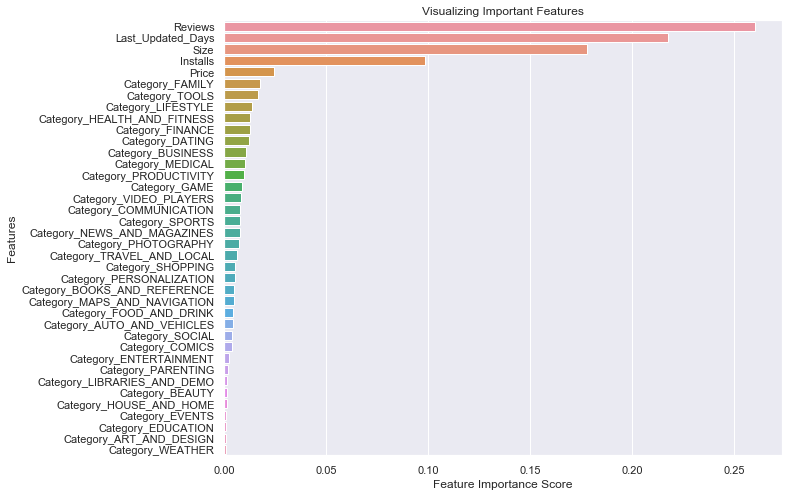

In [113]:
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show();

#### Pricing:

* Logistic Regression (Free VS Paid)
* Tree (Free VS Paid)
* Random Forest (Free VS Paid)
* Linear Regression (predict pricing for paid apps)

To further explore the app price, we build models for inference and prediction on whether an app should be free or be paid. If an app is paid, how to set the price to make it a popular app so as to survive in the app market, which is filled with fierce competitions.

Firstly, we build a **logistic regression model** to predict whether an app should be paid or not. **The accuracy on testing data is 92.74%, beating the baseline 92.56%**. 

Then we used decision tree to further validate our predictions. Because the result for a single tree is not ideal, we extended our tree size to 1000 and used **random forest model**.The **accuracy on testing data is 94.32%**, which beats both the baseline and logistic model. The **true positive rate for prediction is 94.75%**. 

Lastly, for the paid apps, we used the **linear regression model** to explore what factor may affect the actual price for a paid app. The RMSE of our model did not beat the testing data baseline. However, the p-values for Entertainment, Finance, and Lifestyle category is very small. 


**Logistic Regression** (Free VS Paid)

In [140]:
# get dummy variables for X, create categorical variable for y
pd.set_option('display.max_columns', 40)
cols=['Rating', 'Reviews', 'Size', 'Installs', 'Content Rating', 'Pri_Genres']
cat_cols=['Content Rating', 'Pri_Genres']
X = pd.get_dummies(app[cols], columns=cat_cols, prefix='', prefix_sep='', drop_first=True)
y = app[['Type']]
y.loc[ y['Type'] == 'Free', 'Type'] = 0
y.loc[ y['Type'] == 'Paid', 'Type'] = 1
# splite train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From ve

In [215]:
# calculate the baseline
acc = round(1-y_test.sum()/len(y_test), 4)
print('The baseline accuracy for logistic regression is', acc[0])

The baseline accuracy for logistic regression is 0.9256


In [141]:
# build and fit model, predict the probability that an app is free
model = LogisticRegression()
model.fit(X_train,  y_train)
model.predict(X_test)
model.score(X_test, y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.927439024390244

In [143]:
pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_[0]}, columns=['Feature','Coefficient'])

,Feature,Coefficient
0,Rating,-7.965066e-09
1,Reviews,1.193122e-05
2,Size,-5.286160e-08
3,Installs,-5.326447e-06
4,Everyone,-1.785336e-09
5,Everyone 10+,1.874237e-11
6,Mature 17+,-7.542084e-11
7,Teen,-1.461515e-10
8,Unrated,-1.170502e-12
9,Adventure,2.201307e-11


**Tree**

In [155]:
# fit model and calculate the R2 for sample data 
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
print('The out-of-sample R2 is', tree1.score(X_test, y_test))

The out-of-sample R2 is 0.19097600354661082


In [156]:
# Run grid search to find best set of parameters
from sklearn.model_selection import KFold, GridSearchCV
params = {'min_samples_split': [5,10,25,50], 'max_depth': [5,10,25]}
tree_grid = GridSearchCV(estimator=tree1, param_grid=params, scoring='r2', cv=5, n_jobs=4)
%time tree_grid.fit(X_train, y_train)
tree_grid.best_score_

CPU times: user 84.6 ms, sys: 12.4 ms, total: 97 ms
Wall time: 401 ms


0.20176759659334448

In [157]:
# calculate the probaility that an app is free
tree_grid.best_params_
tree = tree_grid.best_estimator_
tree.score(X_test, y_test)

0.19097600354661082

In [158]:
# export the tree graph
export_graphviz(tree, out_file='lending_club_tree.dot', feature_names=X.columns, max_depth=5,
               impurity=False, rounded=True)
!dot -Tpdf lending_club_tree.dot -o lending_club_tree.pdf

**Random Forest** (Free VS Paid)

In [216]:
# build and fit the random forest model 
model_forest = RandomForestClassifier(n_estimators = 100)
model_forest.fit(X_train, y_train)
# predict the probability that an app is free
model_forest.score(X_test, y_test)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.9353658536585366

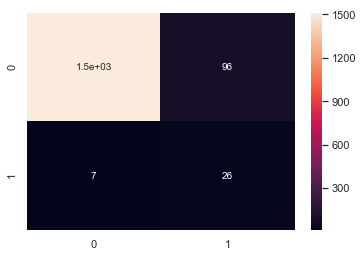

In [169]:
# build confusion metrix for predicted y values
y_predicted = model_forest.predict(X_test)
cm = confusion_matrix(y_predicted, y_test)
sns.heatmap(cm, annot = True)

In [213]:
# calculate the true positive rate for prediction
TPR=cm[0][0]/(cm[0][0]+cm[0][1])
round(TPR, 4)

0.9403

**Linear Regression (predict pricing)**

In [184]:
# select the paid app to analyze the pricing 
cols=['Rating', 'Reviews', 'Size', 'Installs', 'Content Rating', 'Pri_Genres']
cat_cols=['Content Rating', 'Pri_Genres']
app_paid=app[app['Type']=='Paid']

X1 = pd.get_dummies(app_paid[cols], columns=cat_cols, prefix='', prefix_sep='', drop_first=True)
X1 = sm.add_constant(X1)
y1 = app_paid['Price']
pd.concat([X1, y1], axis=1).head()
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=1234)

In [217]:
# calculate the baseline accuracy for testing data
baseline_preds = y1_test.mean()
baseline_RMSE = np.mean(y1_test.apply(lambda x: abs(baseline_preds-x)))
print('Average baseline error for linear regression : ', round(baseline_RMSE, 2))

Average baseline error for linear regression :  19.86


In [189]:
# Fit linear regression model and report results
linear = sm.OLS(y1_train, X1_train).fit()
linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     5.395
Date:                Wed, 08 May 2019   Prob (F-statistic):           4.17e-22
Time:                        19:41:07   Log-Likelihood:                -2556.7
No. Observations:                 483   AIC:                             5207.
Df Residuals:                     436   BIC:                             5404.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      39.7185     24.389      1.629      0.104      -8.215      87.652
Rating                     -8.1930      4.786     -1.712      0.088     -17.600       1.214
Reviews                  3.446e-05   8.13e-05      0.424      0.672      -0.000       0.000
Size                     4.432e-08   1.21e-07      0.365      0.715   -1.94e-07    2.83e-07
Installs                -7.325e-06   1.84e-05     -0.398      0.691   -4.35e-05    2.89e-05
Everyone 10+               -0.1525     12.376     -0.012      0.990     -24.477      24.172
Mature 17+                -19.2583     17.757     -1.085      0.279     -54.158      15.641
Teen                        0.3665     11.581      0.032      0.975     -22.395      23.128
Adventure                   0.1647     20.002      0.008      0.993     -39.148      39.478
Arcade                     -2.4264     17.585     -0.138      0.890     -36.988      32.135
Art & Design                0.6289     38.609      0.016      0.987     -75.253      76.511
Auto & Vehicles             0.1827     52.680      0.003      0.997    -103.356     103.721
Board                      -1.6746     18.740     -0.089      0.929     -38.506      35.157
Books & Reference          -0.9438     23.628     -0.040      0.968     -47.383      45.496
Business                    0.4385     21.865      0.020      0.984     -42.536      43.413
Card                       -2.5430     24.493     -0.104      0.917     -50.682      45.596
Casino                     11.3944     52.418      0.217      0.828     -91.629     114.417
Casual                     -1.7096     18.716     -0.091      0.927     -38.494      35.075
Communication              -3.0108     18.929     -0.159      0.874     -40.215      34.193
Dating                      7.2388     33.879      0.214      0.831     -59.347      73.824
Education                   2.0289     16.252      0.125      0.901     -29.912      33.970
Educational                -3.8589     23.593     -0.164      0.870     -50.230      42.512
Entertainment             132.9796     21.523      6.179      0.000      90.678     175.281
Finance                   178.9603     19.572      9.144      0.000     140.493     217.427
Food & Drink                0.2711     38.547      0.007      0.994     -75.490      76.032
Health & Fitness           -0.1059     24.994     -0.004      0.997     -49.230      49.018
Lifestyle                  73.9921     18.751      3.946      0.000      37.139     110.845
Maps & Navigation          -3.2153     28.924     -0.111      0.912     -60.063      53.633
Medical                     4.3362     15.297      0.283      0.777     -25.729      34.401
Music                      -0.9608     38.181     -0.025      0.980     -76.003      74.081
News & Magazines           10.5831     38.887  

In [214]:
# Predict price for test set, compare to actual price
y_pred = linear.predict(X1_test)
RMSE_lr = np.sqrt(mean_squared_error(y1_test,y_pred))

print('RMSE of linear Regression for Pricing: ', round(RMSE_lr,2))

RMSE of linear Regression for Pricing:  52.61


After comparing our four models built for pricing, we have the following findings:

Although Random forest gives us a higher accuracy rate than baseline, **we still need to reflect on whether payment prediction is an important finding**, in the situation that over 90% of apps are free. For now, the value of the forecast is modest. Based on the modeling of this dataset, we can only recommend developers to launch a free download app in most cases. 

As app users, we think **"free download or not" can no longer well reflect an app pricing strategy.** Through investigation, we find that **a large number of apps are now profitable by providing other paid services after downloading**. This pricing method is called Freemium Pricing Strategy. Unfortunately, our dataset does not contain any variable that evaluates whether an app has additional paid items, which makes the information about price or pricing strategy extremely incomplete, and affects our prediction of price. We suggest that the Google App Store add this information to better reflect the "price" of using the App, which is also very meaningful for consumers.

## <font color=navy>Suggestions</font>

Suggestion and Summary: We put together all the ideas and findings mentioned in the previous sections (basically Feature Engineering and Modeling) here, and the relevant arguments can be found earlier.

**To achieve higher Rating:** 

* Try to get as many as possible user reviews, both positive or negative reviews are very meaningful to improve Rating in the long run.
* Fix bugs in time and update the app frequently and effectively. App updates every six months can beat at least three-quarters of apps.
* The size of apps varies significantly according to the content, so we suggest that it should be designed as small as possible.

**Findings from Pricing:**
* We can predict whether apps should be free through the models we built.
* The dataset lack information about which most apps have the features that users can choose to pay for after free download. This constraints our ability to predicting precise price should a paid app set.

**Suggestions from Review:**
* Increase the number and length of user comments (provide some optional keywords in the comments section).
* Loading time, convenience, and pricing are highly mentioned by users, which indicates that the developers may want to consider these three aspects during designing mainly.
* Adjust the time and length of the ads.

#### Suggestion for Google app store:
* 10-scale rating will be better for app differentiation.
* Add measurement about whether there is payment in the app after free download could better reflect the pricing strategy of an app.

## Thanks for your time :)